# Background

For this project, I am using something related to my work to see if it is possible to classify searches in the [NCBI Nucleotide database]('https://ncbi.nlm.nih.gov/nucleotide') based on whether a user's visit was a successful one or not (a visit is defined as a period activity within a browser that is continuous; unless 30m pass without any user activity, the activity is retained in the same visit).

NCBI is working on improving the search experience, and one goal of that project is to provide knowledge panels or search suggestions that are more likely to lead users to good (or better) results.  Searching for sequences in the Nucleotide database can be very challenging.  The NCBI search infrastrucutre, with the exception of PubMed, is not like that of conventional search engines, the dominate form of search and retrieval processes when using computers, and we are hoping to minimize those differences.

NCBI is currently conducting surveys, and those surveys will provide ground-truth labels for whether a given visit was successful.  In the meantime, for this project, I employ surrogate calsssification labels based on the assumption that the primary goal is to download DNA or RNA sequences from Nucleotide.  So we use weblogs to identify visits that did or did not download a sequence as our 'success' and 'failure' labels, respectively.

# 1. Get Data from AppLog Client
NCBI has an internal web application logging system that records what users search, what pages they view, and what they click on.  We use this ssytem to extract the precise set of data we need for a given analytical task.  For this particular task, we can summarize what we need need to do:
* extract a series of searches from the Nucleotide database, identifying which pages gave those searches, and what visit identifiers they belong to
* use those searches as an input to extract the entire visit activity for that search
* combine those data into one indexed dataset

**NOTE**: This can only be performed at NCBI internally, so the code for data generatation are not executed here, they are generated by executing the get_data.py script in [the repo for this project]('https://github.com/kharo/BIOF509_Final_Project').  Most of this script utilizes command line arguments, but is it included for your contextual understanding.  The data were moved to a public folder in a dropbox account, so we download the data directly via API for this notebook.

# 2. Import Data from Dropbox

In [4]:
# use latest pandas to directly download raw csv content
import pandas as pd
cwd = os.getcwd()
url = 'https://dl.dropbox.com/s/njwmzeb04op9ymz/visit_data.txt?dl=0'  
data = pd.read_csv(url, sep='\t', header=0, dtype=str)

# 3. Randomly Subset Data

In [22]:
import random
# choose the number of visits to analyze - 1K works well for quick verification/illustrative purposes
# the results section will discuss results from 50K visits.
num_samples = 1000
viisits = list(set(data['vid']))
random.seed(21)
random_visits = random.sample(visits, num_samples)
data = data[data['vid'].isin(random_visits)]
data.shape

(43159, 23)

# 4. Define Feature Functions
What is returned from our internal AppLog extraction script is a large matrix of metadata that describes each page render and click for each visit that contained a nucleotide search in the month of October.  We have also returned a column that identifies those original searches, which has been named **anchor_page**

We leverage the data contained in these columns to create features when certain conditions are satisfied.  The features describe certain aspects of a search at NCBI.  All but one feature are based on the search text entered by the user.  The other feature uses the number of results returned from the search.  The features are not randomly made - they are based on a year's worth of other analytical work that suggested there is some sort of correlation between specific user actions and the values of these features.

In the cell below we define the functions to create features and some additional necessary parameters

In [23]:
def has_org(search, org_list):
    '''
    this function examines a search string and checks for the presence of terms
    that are in a list containing popular model organism names
    :param search: string for the user's search
    :param org_list: a list of strings containing organism names
    :return Bool indicating presence/absence of term
    '''
    s = search.split()
    if any([term in org_list for term in s]):
        return True
    else:
        return False

def has_gene(search, gene_list):
    '''
    this function examines a search string and checks for the presence of terms that are in a list 
    containing organism gene names from an internal NCBI database
    :param search: string for the user's search
    :param gene_list: a list of strings containing organism gene symbols, names and more
    :return Bool indicating presence/absence of term
    '''
    s = search.split()
    if any([term in gene_list for term in s]):
        return True
    else:
        return False

def has_boolean(search):
    '''
    looks in string for AND or OR in query to see if user did a boolean search
    :param schear: the string for the user's search
    :return bool: the category for the value
    '''
    if ' and ' in search:
        return True
    elif ' or ' in search:
        return True
    else:
        return False

def has_biol_term(search, term_list):
    '''
    this function looks for specific, custom biological terms set we have used in previous analyses in the user's search
    :param search: string for the user's search
    :param term_list: a list of strings containing special field-specific biology terms
    :return Bool indicating presence/absence of term
    '''
    s = search.split()
    if any([term in term_list for term in s]):
        return True
    else:
        return False

def term_count(search):
    '''
    returns the number of terms from a search using one of three levels
    :param search: string for user's search
    :return str: the category for the value found from counting the number of terms in the search
    '''
    c = len(search.split())
    if c < 2:
        return 'low'
    elif c < 5:
        return 'med'
    else:
        return 'high'

def str_length(search):
    '''
    bins the number of characters in the search string and assigns to one of three levels
    :param search: the search string
    :return str: the category for the value
    '''
    try:
        c = len(search)
    except:
        return 'low'
    if c < 10:
        return 'low'
    elif c < 30:
        return 'med'
    else:
        return 'high'

def bin_result_count(count):
    '''
    bins the number of search results from a given query into three levels
    :param count: the integer value of result counts from the search
    :return str: the category for the value
    '''
    try:
        c = int(count)
    except:
        c = 0
    if c < 20:
        return 'low'
    elif c < 200:
        return 'med'
    else:
        return 'high'

def has_accession(search, patterns):
    '''
    looks for an accession number in the query
    :param search: string for the user's search
    :param patterns: list of regex patterns used to define accession numbers for sequences at NCBI
    :return: Boolean, whether a regex for an accession number is in query
    '''
    indicator = False
    for word in search.split():
        if any([p.search(word) for p in patterns]):
            indicator = True
            break

    if indicator:
        return True
    else:
        return False

def has_identifier(search):
    '''
    looks for a GI identifier in the query, specific to NCBI
    :param search: string for the user's search
    :return: Boolean, whether search is all numeric and thus likely a GI
    '''
    sL = search.split()
    if len(sL) == 1:
        chars = set('0123456789uid.')
        if all((c in chars) for c in sL[0]):
            return True
        else:
            return False
    else:
        return False

def has_sequence(search):
    '''
    looks for a genetic sequence in the query
    :param search: string for the user's search
    :return: Boolean, whether a sequence was used in the search
    '''
    chars = set('atcgu')
    indicator = False
    # split search into terms
    for word in search.split():
        if all((c in chars) for c in word) and len(word) > 10:
            indicator = True
            break
        # this regex is a special identifier for a sequence at NCBI
        elif re.compile("chr\d:\d").search(word):
            indicator = True
            break
    return indicator

def has_taxid(search):
    '''
    looks for a tax ID specifier in the query
    :param search: string for the user's search
    :return: Boolean, whether a taxid is in query
    '''
    indicator = False
    p = re.compile("txid\d")
    # split search into terms
    for word in search.split():
        if p.search(word):
            indicator = True
            break
    if indicator:
        return True
    else:
        return False

import re
# this is a special set of patterns NCBI uses to recognize accession numbers
acc_patterns = []
acc_patterns.append(re.compile("^[a-z]{1}\d{5}\\b"))
acc_patterns.append(re.compile("^[a-z]{2}\d{6}\\b"))
acc_patterns.append(re.compile("^[a-z]{3}\d{5}\\b"))
acc_patterns.append(re.compile("^[a-z]{4}\d{2}\\b"))
acc_patterns.append(re.compile("^[a-z]{4}\d{8}\\b"))
acc_patterns.append(re.compile("^[a-z]{4}\d{10}\\b"))
acc_patterns.append(re.compile("^[a-z]{5}\d{7}\\b"))
acc_patterns.append(re.compile("^[a-z]{2}_"))
acc_patterns.append(re.compile("^[a-z]{3}_"))
acc_patterns.append(re.compile("^[a-z]{3}\s\d{9}\\b"))
acc_patterns.append(re.compile("^samn\d\d"))
acc_patterns.append(re.compile("^prjna\d\d"))
acc_patterns.append(re.compile("^pnusas\d\d"))
acc_patterns.append(re.compile("^samea\d\d"))
acc_patterns.append(re.compile("^cfsan\d\d"))   
acc_patterns.append(re.compile("^gtex\."))
acc_patterns.append(re.compile("^asm\d{5}[a-z]{1}\d{1}\\b"))

# 5. Load Libraries from Dropbox and Execute Feature Generation

In [24]:
# we have stored on file in the same dropbox directory a matrix of term lists
# we convert each relevant row into a set to pass to the functions that require them
url = 'https://dl.dropbox.com/s/d1hosy5g8ztr0ql/terms.txt?dl=0'  
terms = pd.read_csv(url, sep='\t', header=0, dtype=str, na_filter=False)
term_sets = {}
for col in terms:
    # the file has unequal column lengths so we drop the NaN entries before creating the set
    term_sets[col] = set(x.lower() for x in terms[col].tolist() if x != '')

# ensure all searches are strings to avoid string/float errors
data['search_text'] = data['search_text'].apply(str)

# apply feature functions to those that need additional arguments (NOTE: one function uses a count column)
data['org'] = data.apply(lambda x: has_org(x['search_text'], term_sets['org_list']), axis=1)
data['gene'] = data.apply(lambda x: has_gene(x['search_text'], term_sets['gene_list']), axis=1)
data['bio_term'] = data.apply(lambda x: has_biol_term(x['search_text'], term_sets['term_list']), axis=1)
data['has_acc'] = data.apply(lambda x: has_accession(x['search_text'], acc_patterns), axis=1)

# these features do not require additional arguments
data['bool'] = data.apply(lambda x: has_boolean(x['search_text']), axis=1)
data['length'] = data.apply(lambda x: str_length(x['search_text']), axis=1)
data['result_count'] = data.apply(lambda x: bin_result_count(x['count']), axis=1)
data['has_id'] = data.apply(lambda x: has_identifier(x['search_text']), axis=1)
data['has_seq'] = data.apply(lambda x: has_sequence(x['search_text']), axis=1)
data['has_tax'] = data.apply(lambda x: has_taxid(x['search_text']), axis=1)
data['term_count'] = data.apply(lambda x: term_count(x['search_text']), axis=1)

# 6. Label Generation
Similar to features, we use the data within a visit to create a success or failure label.  Intellectually speaking, we *would* define success as someone who comes to NCBI and finds what they want.  We are working on obtaining those data currently via surveys.  For the purposes of this analysis, we create artifical features here.

We will define success based on institutional knowledge and user interviews as someone who viewed (FASTA) or downloaded a sequence from a Nucleotide record.  Eventuslly, our group plans to use user surveys to define a success or failure based on answers from this question: "Did you find what you were looking for today?".  In the meantime, the surrogate success label executes the following logic:
* subset data for each visit
* find the first "anchor search" in each visit, after time sorting (some visits may have more than one search, so we only use the first one if that is the case)
* examine all rows after that search to look for matches to the conditions which specify a successful visit

In [25]:
def docsum_fasta(row, col1, col2, col3, col4):
    '''
    this function looks for conditions that mean someone clicked to see a FASTA record directly from a docsum page
    :param col1: str for column with jsevent
    :param col2: str for column with the NCBI database
    :param col3: str for column with the NCBI page type
    :param col4: str for column with the link source attribute
    '''
    indicator = False
    if (
        row[col1] == 'click' and row[col2] == 'nuccore' and row[col3] == 'docsum'
        and row[col4] == 'docsum_fasta' 
    ):
        indicator =  True
    return indicator

def genbank_to_fasta(row, col1, col2, col3, col4):
    '''
    this function looks for conditions that mean someone switched to FASTA view from GenBank view on a record page
    :param col1: str for column with jsevent
    :param col2: str for column with the NCBI database
    :param col3: str for column with the NCBI page type
    :param col5: str for column with the link text
    '''
    indicator = False
    if (
        row[col1] == 'click' and row[col2] == 'nuccore' and row[col3] == 'genbank'
         and row[col4] == 'fasta'
    ):
        indicator =  True
    
    return indicator

def download_docsum(row, col1, col2, col3, col4):
    '''
    this function looks for conditions that mean someone downloaded records from a docsum page
    :param col1: str for column with jsevent
    :param col2: str for column with the NCBI database
    :param col3: str for column with the NCBI page type
    :param col4: str for column with the link_action_name attribute
    '''
    indicator = False
    if (
        row[col1] == 'click' and row[col2] == 'nuccore' and row[col3] == 'docsum'
        and row[col4] == 'create file'
    ):
        indicator =  True
    
    return indicator
    
def download_record(row, col1, col2, col3, col4):
    '''
    this function looks for conditions that mean someone downloaded a FASTA record from a record page
    :param col1: str for column with jsevent
    :param col2: str for column with the NCBI database
    :param col3: str for column with the NCBI page type
    :param col4: str for column with the link_action_name attribue
    '''
    indicator = False
    if (
        row[col1] == 'click' and row[col2] == 'nuccore' and row[col3] in ['genbank', 'fasta', 'summary', 'asn.1']
        and row[col4] == 'create file'
    ):
        indicator =  True

    return indicator

# provide the column names needed for each function
col_names_docsum_fasta = ('jsevent', 'ncbi_db', 'ncbi_pdid', 'link_src')
col_names_genbank_fasta = ('jsevent', 'ncbi_db', 'ncbi_pdid', 'link_text')
col_names_download_docsum = ('jsevent', 'ncbi_db', 'ncbi_pdid', 'link_action_name')
col_names_download_record = ('jsevent', 'ncbi_db', 'ncbi_pdid', 'link_action_name')

# here we loop through each visits, test if any of the 4 conditions are met, and assign the label as success or failuer
labels = {}
# save each first anchor page to consolidate core data for model
indeces = []
visits = list(set(data['vid']))
data.sort_values(['vid', 'datetime'], inplace=True)
ct = 0
successes = [0, 0, 0, 0]
for visit in visits:
    temp = data[data['vid'] == visit]
    # this try statement catches mal-indexed visits that don't have anchor page even though they all should
    # this is from background errors we sometimes receive from the AppLog client
    try:
        idx = temp[temp['anchor_page'] == 'yes'].index.values[0]
        ct += 1
    except:
        # if no anchor page, skip this visit
        continue
    indeces.append(idx)
    df = temp.loc[idx::]
    cond1 = df.apply(docsum_fasta, args=(col_names_docsum_fasta), axis=1)
    if cond1.sum() > 0:
        labels[visit] = 'success'
        successes[0] += 1
        continue
    cond2 = df.apply(genbank_to_fasta, args=(col_names_genbank_fasta), axis=1)
    if cond2.sum() > 0:
        labels[visit] = 'success'
        successes[1] += 1
        continue
    cond3 = df.apply(download_docsum, args=(col_names_download_docsum), axis=1)
    if cond3.sum():
        labels[visit] = 'success'
        successes[2] += 1
        continue
    cond4 = df.apply(download_record, args=(col_names_download_record), axis=1)
    if cond4.sum():
        labels[visit] = 'success'
        successes[3] += 1
    else:
        labels[visit] = 'failure'
succ_tot = 0
for i in successes:
    succ_tot += i
summary_print = 'There are ' + str(len(labels) - succ_tot) + ' unsuccessful visits and '
summary_print += str(succ_tot) + ' successful visits'
print(summary_print)

There are 554 unsuccessful visits and 210 successful visits


# 7. Final Data Cleanup and Simplification, Quantify Numeric Vectors, Generate [X, y] and Perform Train-Validate-Test Split
We do some final data cleanup to remove non-labeled visits, only use one row per visit, which comes for the initial search in the visit.

**A note on categorical variables**: While sci-kit learn requires numeric data and normally one would one-hot encode, in our case the categorical variables *do* have ordinal relationships, so rather than creating binary vectors for each category level, we use numerical relationships.  So we use [1,2,3] in lieu of ['low', 'med', 'high'].  It is trivial enough to use one-hot encoding for future analyses if necessary.

Finally, only our created feature columns are needed for our feature matrix X; we then split our data randomly into training and test data.

In [32]:
from sklearn.model_selection import train_test_split
# only include the first "anchor" search in each visit to generate the model
# we stored the indeces in a list of the same name from the previous step
final_df = data[data.index.isin(indeces)]
final_df['label'] = final_df['vid'].map(labels).fillna('NoLabel')

# ensure no unlabeled data in matrix (this happens from errors in the initial dataset)
final_df = final_df[final_df['label'] != 'NoLabel']

# balance the number of successful vs failed visits 
corr = final_df[final_df['label'] == 'success']
wrong = final_df[final_df['label'] == 'failure']
wrong = wrong.sample(corr.shape[0])
frames = [corr, wrong]
final_df = pd.concat(frames)

# extract labels and convert to binary numeric
y = final_df['label']
y_labels = y
y = [1 if i == 'success' else 0 for i in y]

# remove label and make the visit ID the index value since it is not used in the model
final_df.index = final_df['vid']
final_df = final_df[['org', 'gene', 'bool', 'bio_term', 'term_count', 'length', 'result_count', 'has_acc', 'has_id', 'has_seq', 'has_tax']]

# convert categorical, ordinal features to numeric - note this is NOT one-hot encoding! (see above)
for col in ['term_count', 'length', 'result_count']:
    final_df[col] = final_df[col].map({'low': 1, 'med': 2, 'high': 3})

# convert boolean vectors to binary numeric
for col in final_df:
    if col not in ['term_count', 'length', 'result_count']:
        final_df[col] = final_df[col].map({True: 1, False: 0})

# split training and test with 30% test
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=0.3, stratify=y)
print('The final model size for our training set is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]))
print(str(sum(y_train)) + ' of these ' + str(X_train.shape[0]) + ' training samples are successful')

# convert numeric labels back to strings for plots later
y_labels = ['success' if i == 1 else 'failure' for i in y_test]

The final model size for our training set is 294 by 11
147 of these 294 training samples are successful


/Users/kjh/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 8. Build Decision Tree Model
We want to classify a successful visit by features we find as a result of the user's first search in the visit.  This is a supervised classification problem that does not involve regression.  For interpretaibility, we will apply a decision tree, which will allow us to see what the most important features are.  They are also fairly speedy.  We will see if the tree depth has any effect on the accuracy

In [33]:
# fit model using decision tree class
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
for depth in [3, 5, 7]:
    dtc = DecisionTreeClassifier(random_state=21, max_depth=depth)
    dtc.fit(X_train, y_train)

    # store predicted values and calculate accuracy
    y_pred = dtc.predict(X_test)
    print('classification score with a depth of ' + str(depth) + ' is ' + str(dtc.score(X=X_test, y=y_test)))

classification score with a depth of 3 is 0.5555555555555556
classification score with a depth of 5 is 0.5238095238095238
classification score with a depth of 7 is 0.5317460317460317


# 9. Evaluate Model Metrics
We can use standard metrics libraries from sci-kit learn to deal with

In [34]:
# evaluate sci-kit learn metrics for decision tree classification matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy and performance of Decision Tree Classifier with ' + str(depth) + ' layers:')
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
print(accuracy_score(y_test, y_pred))

Accuracy and performance of Decision Tree Classifier with 7 layers:
[[26 37]
 [22 41]]
             precision    recall  f1-score   support

          0       0.54      0.41      0.47        63
          1       0.53      0.65      0.58        63

avg / total       0.53      0.53      0.53       126

0.5317460317460317


# 10. Visualize Model with Graphviz
The plot type allows us to examine the decision nodes from the tree model easily.

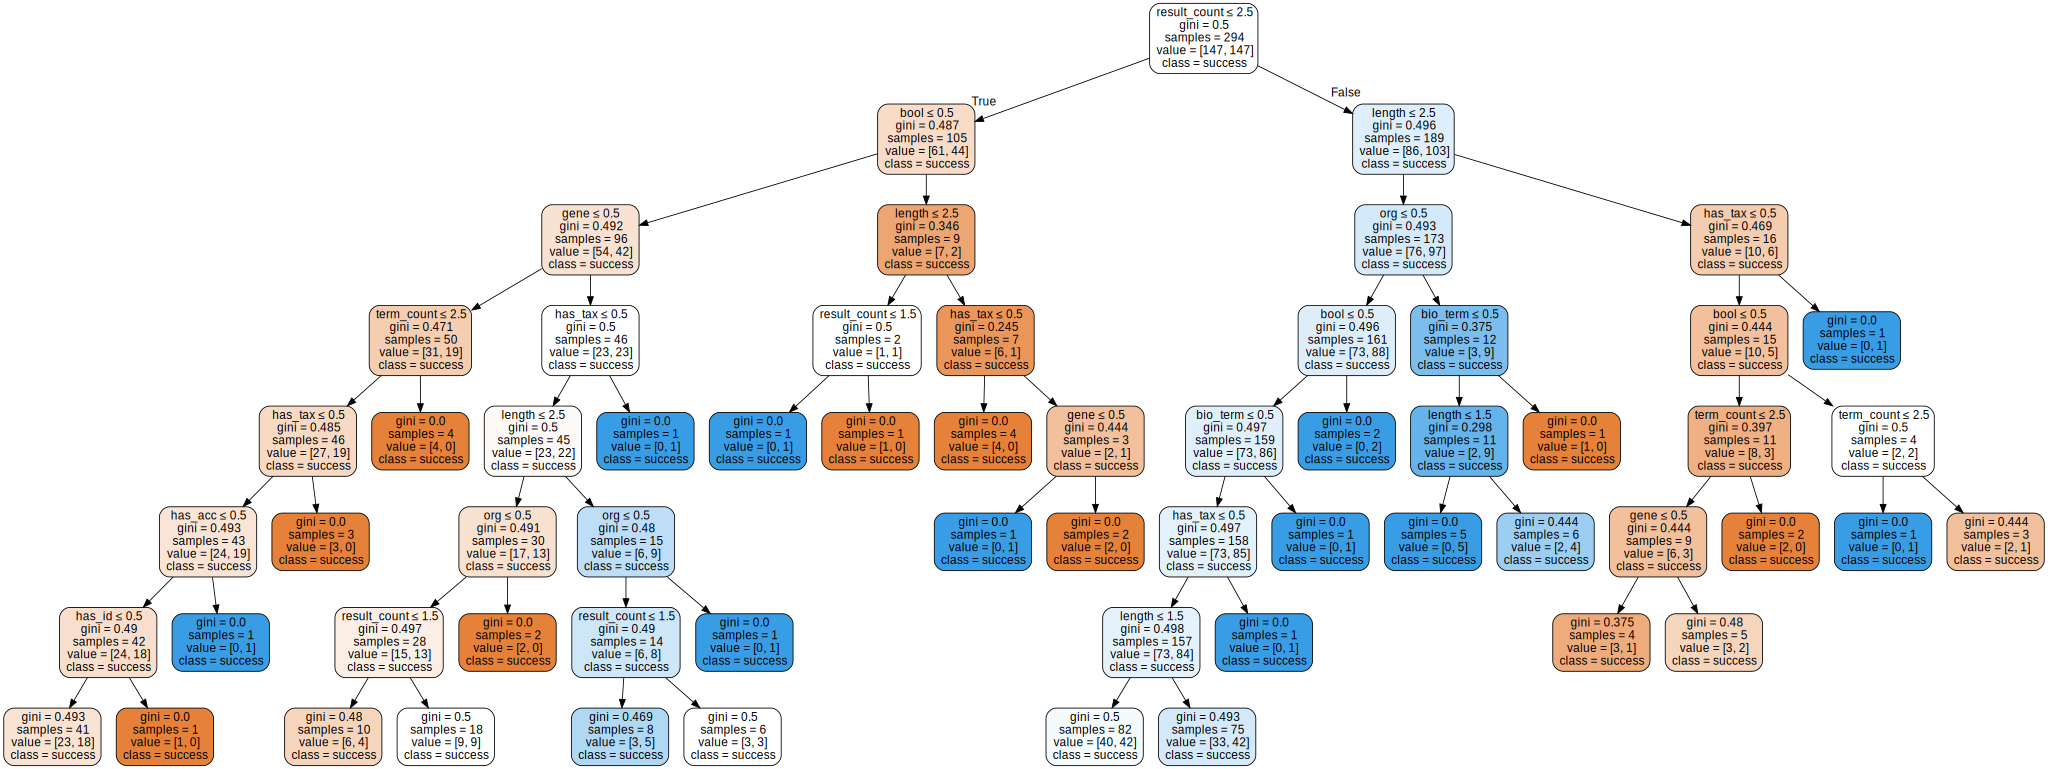

In [41]:
# use graphviz to visualize trees
import graphviz
from sklearn import tree
# convert training labels back to original categories
dot_data = tree.export_graphviz(dtc, out_file=None, feature_names=X_train.columns,
                      class_names=y_labels, filled=True, rounded=True, special_characters=True)  
graphviz.Source(dot_data)

# Discussion of Results
There are 29173 unsuccessful visits and 11737 successful visits
The final model size for our training set is 16431 by 11
8215 of these 16431 training samples are successful
Accuracy and performance of Decision Tree Classifier with 3 layers:
[[1809 1712]
 [1697 1825]]
             precision    recall  f1-score   support

          0       0.52      0.51      0.51      3521
          1       0.52      0.52      0.52      3522

avg / total       0.52      0.52      0.52      7043

0.5159733068294761
0.5276160726962942
Accuracy and performance of Random Forests on non-normalized data with 20 estima
tors:
[[2059 1462]
 [1865 1657]]
             precision    recall  f1-score   support

          0       0.52      0.58      0.55      3521
          1       0.53      0.47      0.50      3522

avg / total       0.53      0.53      0.53      7043

0.5276160726962942

# Supplemental: Training a Random Forest Model
Decision trees are great for interpretation, are fast, and can handle numerical and categorical data.  But these advanatages come with caveats; they are prone to biases and overfitting.  Random Forests use sampling to reduce bias and overfitting.  To use Random Forests, we would need to perform one-hot encoding, and we would also want to see the effect of scaling

We will perform these steps below to generare a Random Forest Classifier.

In [15]:
# import class for random forest calssifcation and apply on train data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=21)  
rfc.fit(X_train, y_train)  
y_pred = rfc.predict(X_test)
print(rfc.score(X_test, y_test))

# repeat but apply scaling to X_train and X_test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
X_train_sc = scaler.fit_transform(X_train)  
X_test_sc = scaler.transform(X_test)

rfc = RandomForestClassifier(n_estimators=20, random_state=21)  
rfc.fit(X_train_sc, y_train)  
y_pred_sc = rfc.predict(X_test_sc)
rfc.score(X_test_sc, y_test)

0.5098901098901099


/Users/kjh/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.5098901098901099

Scaling seems to have no effect on the random forest model, perhaps due to all of the features being cetgorical, and thus not having variance differences like continuous features would

# Evaluate model using precision-recall curves

In [16]:
# again we leverage the metrics from sci-kit learn
print('Accuracy and performance of Random Forests on non-normalized data with 20 estimators:')
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

Accuracy and performance of Random Forests on non-normalized data with 20 estimators:
[[288 394]
 [275 408]]
             precision    recall  f1-score   support

          0       0.51      0.42      0.46       682
          1       0.51      0.60      0.55       683

avg / total       0.51      0.51      0.51      1365

0.5098901098901099


Text(0.5, 1.0, '2-class Precision-Recall curve on Random Forest Classifier Using Normalized Data AP=0.51')

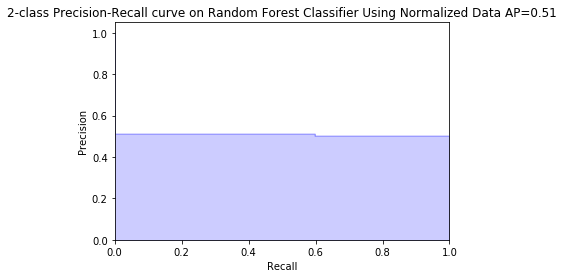

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)
%matplotlib inline

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve on Random Forest Classifier Using Normalized Data AP={0:0.2f}'.format(average_precision))